# Titanic competition via PCA + logistic regression

Here, we will be combining PCA with logistic regression.

We start by loading the data which we have cleaned in the notebook `titanic_data_cleaning.ipynb`.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [2]:
titanic = pd.read_csv( 'train_cleaned.csv' )
test = pd.read_csv( 'test_cleaned.csv' )

Remove the 'PassengerId' from the data and keep the 'Survived' column as our target vector $Y$.

In [3]:
submission=test[['PassengerId']]
test=test.drop('PassengerId', axis=1)

X=titanic.drop('Survived', axis=1)
X=X.drop('PassengerId', axis=1)
Y=titanic[['Survived']]
data=X.to_numpy()
target=Y.to_numpy().reshape(-1,)

# Regularization

Define a pipeline to search for the best combination of PCA truncation and classifier regularization.

As the data visualisation part of `titanic_data_cleaning.ipynb` suggests, the decision boundaries may be quite nonlinear. Thus, we will be using polynomial features of degree $2$.

In [4]:
pca = PCA()

# Define quadratic features
poly = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

In [5]:
logistic = LogisticRegression(max_iter=10000)

Let's first see how PCA looks like in the polynomial feature space.

Shape of the polynomial features data:	(891, 405)


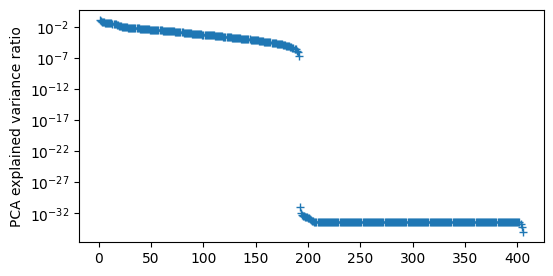

In [6]:
X_poly = poly.fit_transform(data)
X_poly_scaled = scaler.fit_transform(X_poly)

print("Shape of the polynomial features data:\t" + str(X_poly_scaled.shape))

pca.fit(X_poly_scaled)

fig, ax0 = plt.subplots(nrows=1, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_yscale('log')
ax0.set_ylabel("PCA explained variance ratio")

ax0.set_box_aspect(.5)

There is a clear cutoff in `pca.explained_variance_ratio_` after `n_components`$>190$.

Next, we conveniently pipeline the entire process.

In [7]:
pipe = Pipeline(
    steps=[('polynomial_features',poly), ("scaler", scaler), ("pca", pca), ("logistic", logistic)]
)

We will perform a parameter grid search.

In [8]:
param_grid = {
    "pca__n_components": range(5,190,5),
    "logistic__C": np.logspace(-4, 4, 18),
}

Running the cell below may take a few minutes.

In [9]:
search = GridSearchCV(
    pipe, param_grid, n_jobs=-1, cv=StratifiedKFold(
        shuffle=True, random_state=1234
    )
)

search.fit(data, target)

print(
    "Best parameter (CV score=%0.3f):" % search.best_score_
)

print(search.best_params_)

Best parameter (CV score=0.835):
{'logistic__C': 0.06660846290809154, 'pca__n_components': 55}


For each number of components, we plot the best classifier results.

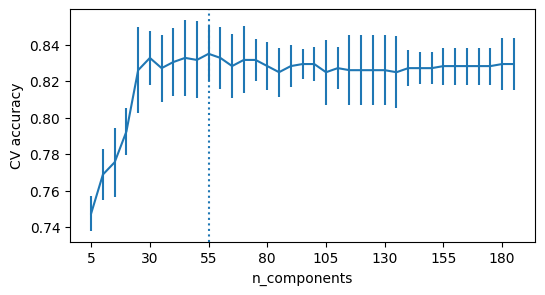

In [10]:
fig, ax1 = plt.subplots(nrows=1, figsize=(6, 6))
results = pd.DataFrame(search.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score")
)

best_clfs.plot(
    x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
)

ax1.axvline(
    search.best_params_['pca__n_components']/5-1,
    linestyle=":"
)

ax1.set_ylabel("CV accuracy")
ax1.set_xlabel("n_components")
ax1.set_box_aspect(.5)

## Make the predictions

In [11]:
params = {
        'logistic__C': search.best_params_['logistic__C'], 'pca__n_components': search.best_params_['pca__n_components']
    }
pipe.set_params(**params)

pipe.fit(data, target)
y_pred=pipe.predict(data)
y_true=Y.values.T[0]
print(
    "Training accuracy:\t"+str( accuracy_score(y_true, y_pred) )
)

Training accuracy:	0.8597081930415263


The training accuracy is comparable with the CV accuracy, so we have avoided overfitting.

In [12]:
submission["Survived"]=pipe.predict(test)
print( submission.head() )

submission.to_csv(
    'submission_poly_pca_logistic.csv',index=False
)

   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
